In [1]:
import os                                                                         # импортируем часть библиотеки для взаимодействия с данными на
                                                                                  # компьютере и для доступа к окружению, где запущен notebook
from random import sample                                                         # random - часть библиотеки, которая отвечает за случайные числа

import numpy as np                                                                # библиотека для работы с векторами и матрицами

import torch                                                                      # тут все нейронные сети
import torch.nn as nn                                                             # тут все блоки нейронных сетей, слои
import torch.nn.functional as F                                                   # функции, которые нам пригодятся

import matplotlib.pyplot as plt                                                   # для построения графиков
from IPython.display import clear_output   

from sklearn.model_selection import train_test_split                            # для разделения данных на обучающую и тестовую выборки

from datasets import load_dataset

c:\Users\Денис\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = load_dataset("agentlans/high-quality-english-sentences")

In [5]:
train_ds = dataset["train"][:]["text"]


test_ds = dataset["test"][:]["text"]


val_ds, test_ds = train_test_split(test_ds, test_size=0.7, random_state=42)

print(f"Валідаційна вибірка: {len(val_ds)} прикладів, Тестова: {len(test_ds)} прикладів")
print(train_ds[0])

Валідаційна вибірка: 51156 прикладів, Тестова: 119366 прикладів
Soon we dropped into a living forest, where cold-tolerant evergreens and boreal animals still evoke the Canadian heritage of an ecosystem pushed south by glaciers 20,000 years ago.


In [3]:
from nltk.tokenize import WordPunctTokenizer

tokenizer = WordPunctTokenizer()

print(tokenizer.tokenize("Hello world! This is a test sentence."))
print([word for word in tokenizer.tokenize("Hello world! This is a test sentence.") if word.isalpha()])

['Hello', 'world', '!', 'This', 'is', 'a', 'test', 'sentence', '.']
['Hello', 'world', 'This', 'is', 'a', 'test', 'sentence']


In [6]:
def my_tokenize(sentence):
    return [token for token in tokenizer.tokenize(sentence.rstrip().lower()) if token.isalpha()]

print(my_tokenize(train_ds[0]))

['soon', 'we', 'dropped', 'into', 'a', 'living', 'forest', 'where', 'cold', 'tolerant', 'evergreens', 'and', 'boreal', 'animals', 'still', 'evoke', 'the', 'canadian', 'heritage', 'of', 'an', 'ecosystem', 'pushed', 'south', 'by', 'glaciers', 'years', 'ago']


In [7]:
from collections import Counter

def build_vocab(sentences, min_freq=10):
    word_counter = Counter()

    for sentence in sentences:
        tokenized_sentence = my_tokenize(sentence)
        for word_punkt in tokenized_sentence:
            word_counter[word_punkt] += 1

    vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])

    for char, cnt in word_counter.items():
        if cnt > min_freq:
            vocab.add(char)
    
    return vocab

In [8]:
vocab = build_vocab(train_ds, min_freq=25)

print("Кількість слів у словнику: ", len(vocab))

Кількість слів у словнику:  32414


In [9]:
word2ind = {token: i for i, token in enumerate(vocab)}
ind2word = {i: token for token, i in word2ind.items()}

Гістограма розподілу довжин речень.

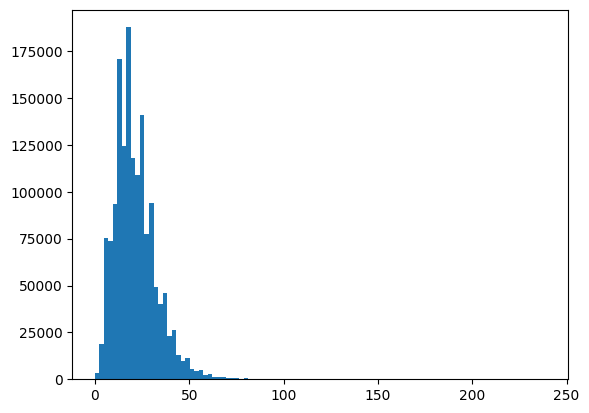

In [210]:
plt.hist([len(my_tokenize(x)) for x in train_ds], bins=100);

In [10]:
def collate_fn(input_batch, max_len=50):
    """
    params: input_batch - a list of tokenized strings
    """
    seq_lens = [len(x) for x in input_batch]
    max_seq_len = min(max(seq_lens) + 2, max_len) # +2 for <bos> and <eos>

    processed_texts = []

    for tokens_lst in input_batch:
        tokens_lst = tokens_lst[:max_seq_len - 2]

        indexed = [word2ind['<bos>']]
        indexed += [word2ind[x] if x in vocab else word2ind['<unk>'] for x in tokens_lst]
        indexed += [word2ind['<eos>']]

        for _ in range(max_seq_len - len(indexed)):
            indexed += [word2ind['<pad>']]
            
        processed_texts.append(indexed)

    return torch.LongTensor(processed_texts)

In [11]:
train_ds_tokenized = [my_tokenize(sentence=sent) for sent in train_ds]

In [213]:
print(collate_fn(train_ds_tokenized[:3]))

tensor([[ 2129, 30634,  3496,  2476, 19289, 13438, 28416,  7405, 29183,  6204,
         18220, 11921, 22840, 26913, 29460, 21609, 31833, 11881, 17694, 14180,
         19600, 31727, 30286, 16326, 24244,  4020,  9954,  9481, 16634,   103],
        [ 2129, 30172,  7147, 17403, 22039,  1133, 18829, 16940,   135,   103,
         14543, 14543, 14543, 14543, 14543, 14543, 14543, 14543, 14543, 14543,
         14543, 14543, 14543, 14543, 14543, 14543, 14543, 14543, 14543, 14543],
        [ 2129,  5652, 18701, 13051, 14840, 11881, 10166, 21137, 19600,   135,
          2697, 11881, 17915, 32271, 11881,  4518, 22840, 10702, 26208, 21609,
          3308,  5652, 25181, 31253,   103, 14543, 14543, 14543, 14543, 14543]])


In [12]:
class WordRNNLoop(nn.Module):

    def __init__(self, num_of_tokens=len(vocab), emb_size=256, rnn_num_units=512):
        super().__init__()
        self.emb = nn.Embedding(num_of_tokens, emb_size, padding_idx=14543)

        self.lstm = nn.LSTM(
            input_size=emb_size,
            hidden_size=rnn_num_units,
            num_layers=2,
            dropout=0,
            batch_first=True
        )

        # self.rnn = nn.RNN(emb_size, rnn_num_units, batch_first=True)
        self.hid_to_logits = nn.Linear(rnn_num_units, num_of_tokens)

    def forward(self, x):
        h_seq, hidden = self.lstm(self.emb(x))
        next_logits = self.hid_to_logits(h_seq)
        return next_logits


In [229]:
model = WordRNNLoop()
opt = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

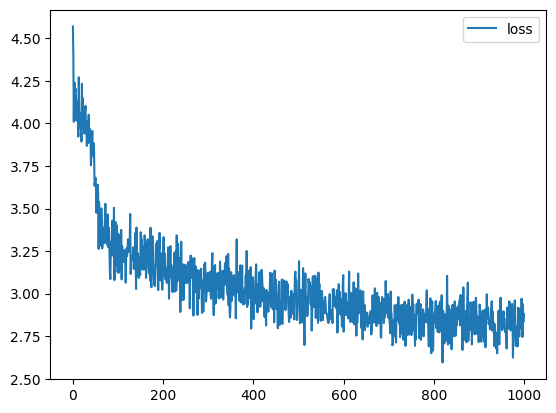

In [233]:
history = []

for epoch in range(1000):
    print("epoch: ", epoch)

    batch_ix = collate_fn(sample(train_ds_tokenized, 256))
    batch_ix = torch.LongTensor(batch_ix)

    logits = model(batch_ix)

    predictions_logp = F.log_softmax(logits[:, :-1], dim=-1)
    actual_next_tokens = batch_ix[:, 1:]

    loss = criterion(
        predictions_logp.contiguous().view(-1, len(vocab)),
        actual_next_tokens.contiguous().view(-1)
    )

    # Обучение методов backprop
    loss.backward()                                                               # посчитали градиенты
    opt.step()
    opt.zero_grad()

    # код отрисовки графика
    history.append(loss.item())
    if (epoch+1)%100==0:                                                              # на каждом сотом шаге обновляем график
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "RNN didn't converge."


In [15]:
def generate_sample(model, seed_phrase=[' '], max_length=50, temperature=1.0):
    '''
    The function generates text given a phrase of length at least SEQ_LENGTH.
    :param seed_phrase: prefix characters. The RNN is asked to continue the phrase
    :param max_length: maximum output length, including seed_phrase
    :param temperature: coefficient for sampling.  higher temperature produces more chaotic outputs,
                        smaller temperature converges to the single most likely output
    '''

    x_sequence = [word2ind[token] for token in seed_phrase]                    # преобразуем seed_phrase в последовательность индексов токенов
    x_sequence = torch.tensor([x_sequence], dtype=torch.int64)

    #start generating
    for _ in range(max_length - len(seed_phrase)):
        logits = model(x_sequence)                                                # новое скрытое состояние и логит для след токена - это
                                                                                  # последний элемент последовательности и текущее скрытое состояние
        p_next = F.softmax(logits / temperature, dim=-1).data.numpy()[0][-1]      # считаем вероятность: softmax от текущих логитов
                                                                                  # temperature отвечает за случайность (гиперпараметр)

        # sample next token and push it back into x_sequence
        next_ix = np.random.choice(len(vocab), p=p_next)                           # из всех токенов с распределением p_next
        next_ix = torch.tensor([[next_ix]], dtype=torch.int64)
        x_sequence = torch.cat([x_sequence, next_ix], dim=1)                      # добавляем к последовательности

    return ' '.join([ind2word[ix] for ix in x_sequence.data.numpy()[0]])             # возвращаем все, сконкатенировав через пустую строку

In [258]:
for _ in range(10):
    print(generate_sample(model, seed_phrase=my_tokenize("Soon we dropped into a living forest"), temperature=0.8))

soon we dropped into a living forest which would be able to the global portion of the personal action of a atmosphere <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
soon we dropped into a living forest planet in the first republican period of the profit body <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
soon we dropped into a living forest <eos> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
soon we dropped into a living forest of a unique number of the surprise and the department of a world <eos> <pad> <pad> <pad> <